In [214]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [215]:
excel_path = r'../data/multi_asset_etf_data.xlsx'
df_descriptions = pd.read_excel(excel_path, sheet_name="descriptions")
df_excess_returns = pd.read_excel(excel_path, sheet_name="excess returns")
df_total_returns = pd.read_excel(excel_path, sheet_name="total returns")
df_prices = pd.read_excel(excel_path, sheet_name="prices")

In [261]:
def er_to_summary_stats(df_excess_returns, scale: float=1.0):
    summary_data = {
        'Mean': df_excess_returns.mean() * scale,
        'Volatility': df_excess_returns.std() * scale ** 0.5,
    }

    # Create a DataFrame from the summary data
    df_summary_stats = pd.DataFrame(summary_data)

    df_summary_stats['Sharpe'] = df_summary_stats['Mean'] / df_summary_stats['Volatility']
    df_summary_stats = df_summary_stats.sort_values(by="Sharpe", ascending=False)
    return df_summary_stats

def plot_correlation_heatmap(correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

def get_high_low_from_corr_matrix(correlation_matrix):
    highest_corr = 0
    highest_corr_pair = ()
    lowest_corr = 1
    lowest_corr_pair = ()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > abs(highest_corr):
                highest_corr = correlation
                highest_corr_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            if abs(correlation) < abs(lowest_corr):
                lowest_corr = correlation
                lowest_corr_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
    return lowest_corr_pair, lowest_corr, highest_corr_pair, highest_corr

def calculate_optimal_portfolio_weights(df_excess_returns, custom_cov_matrix=None):
    vec_mean = df_excess_returns.mean().values
    df_cov = df_excess_returns.cov().values if custom_cov_matrix is None else custom_cov_matrix
    df_inv_corr = np.linalg.inv(df_cov)
    vec_optimal_weights = (1/(np.ones(df_inv_corr.shape[0]) @ df_inv_corr @ vec_mean.T)) * (df_inv_corr @ vec_mean.T)
    return vec_optimal_weights

def series_weight_to_summary_stats(df_excess_return, portfolio_weights, scale: float=1.0, target_return: float=None):
    port_return_series = pd.DataFrame(df_excess_return.values @ portfolio_weights.T, columns=["Portfolio Stats"])
    summary_stats = er_to_summary_stats(port_return_series, scale=scale)
    if target_return:
        summary_stats["Mean"] = target_return
        summary_stats["Volatility"] = target_return / summary_stats["Sharpe"]
    return summary_stats




# 2. Mean-Variance Framwork

## 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
* Which assets have the best and worst Sharpe ratios? Recall that the Sharpe Ratio is simply the ratio of the mean-to-volatility of excess returns:
$$\text{sharpe ratio of investment }i = \frac{\mux_i}{\sigma_i}$$

### 1.1

In [217]:
# 1.1
df_summary_stats = er_to_summary_stats(df_excess_returns.iloc[:,1:], scale=12)
df_summary_stats

,Mean,Volatility,Sharpe
SPY,0.143727,0.147679,0.973244
HYG,0.064168,0.089154,0.719744
IYR,0.129473,0.187101,0.691996
EFA,0.081597,0.165991,0.491574
TIP,0.022321,0.051529,0.433165
QAI,0.018974,0.050810,0.373439
PSP,0.079938,0.227386,0.351552
EEM,0.064887,0.196531,0.330163
IEF,0.014269,0.062405,0.228651
DBC,0.025443,0.178975,0.142162


### 1.2
SPY, HYG, IYR have the best sharpe ratios.
BWX, DBC, IEF have the worst sharpe ratios.

## 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

### 2.1 Correlation

In [218]:
# 1.2
df_er_corr = df_excess_returns.iloc[:,1:].corr()
df_er_corr


,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
BWX,1.000000,0.349771,0.647612,0.621660,0.557653,0.434471,0.453534,0.524869,0.668043,0.465713,0.617098
DBC,0.349771,1.000000,0.565654,0.581864,0.473207,-0.321738,0.318314,0.496057,0.547935,0.509887,0.136667
EEM,0.647612,0.565654,1.000000,0.851579,0.726041,-0.102348,0.621814,0.771677,0.807244,0.734556,0.302729
EFA,0.621660,0.581864,0.851579,1.000000,0.771463,-0.132334,0.697875,0.891930,0.853673,0.871641,0.287477
HYG,0.557653,0.473207,0.726041,0.771463,1.000000,-0.008601,0.757651,0.823823,0.768754,0.770354,0.365939
IEF,0.434471,-0.321738,-0.102348,-0.132334,-0.008601,1.000000,0.073618,-0.118680,0.055669,-0.155697,0.706079
IYR,0.453534,0.318314,0.621814,0.697875,0.757651,0.073618,1.000000,0.760158,0.655963,0.753610,0.397167
PSP,0.524869,0.496057,0.771677,0.891930,0.823823,-0.118680,0.760158,1.000000,0.838286,0.895730,0.320913
QAI,0.668043,0.547935,0.807244,0.853673,0.768754,0.055669,0.655963,0.838286,1.000000,0.840989,0.459714
SPY,0.465713,0.509887,0.734556,0.871641,0.770354,-0.155697,0.753610,0.895730,0.840989,1.000000,0.294641


Highest Correlation Pair: ('PSP', 'SPY')
Highest Correlation Coefficient: 0.8957295508415989
Lowest Correlation Pair: ('HYG', 'IEF')
Lowest Correlation Coefficient: -0.008600718854729069


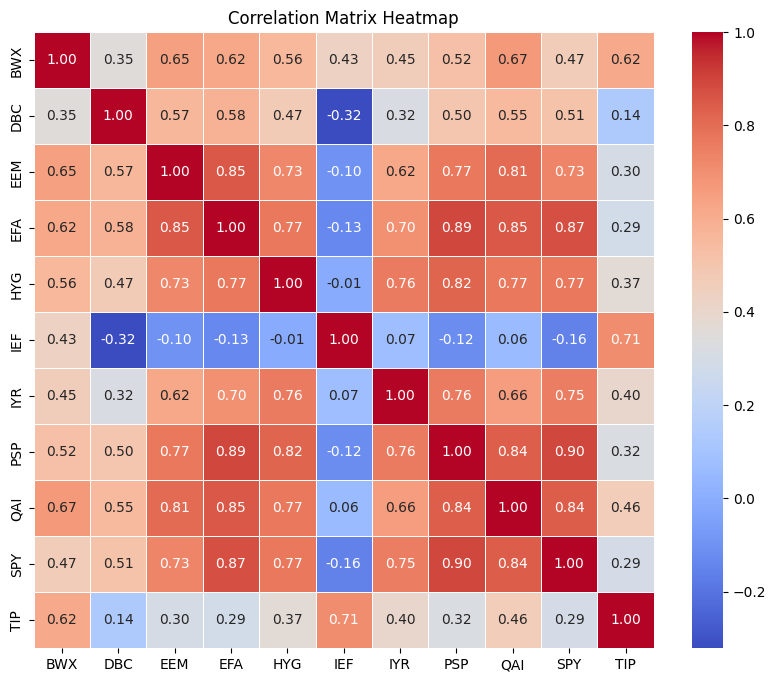

In [219]:
lowest_corr_pair, lowest_corr, highest_corr_pair, highest_corr= get_high_low_from_corr_matrix(df_er_corr)

# Print the highest correlation pair and its correlation coefficient
print(f"Highest Correlation Pair: {highest_corr_pair}")
print(f"Highest Correlation Coefficient: {highest_corr}")
print(f"Lowest Correlation Pair: {lowest_corr_pair}")
print(f"Lowest Correlation Coefficient: {lowest_corr}")
plot_correlation_heatmap(df_er_corr)

We can see that PSP and SPY have the highest absolute correlation.
HYG and IEF have the lowest absolute correlation.

### 2.2 TIPS Performance

In [220]:
df_summary_stats.loc[["TIP","HYG","BWX"]]

,Mean,Volatility,Sharpe
TIP,0.022321,0.051529,0.433165
HYG,0.064168,0.089154,0.719744
BWX,-0.001843,0.083359,-0.022113


TIPS looked to have underperformed HYG (Domestic corperate bonds) in terms of sharpe but outperformed BWS foreign bonds in terms of sharpe.

## 3. The MV frontier.
* Compute and display the weights of the tangency portfolios: $\wtan$.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to $\wtan$.

### 3.1 Weights of Tangency Portfolio

In [221]:
vec_optimal_weights = calculate_optimal_portfolio_weights(df_excess_returns.iloc[:,1:])
vec_optimal_weights = pd.DataFrame(vec_optimal_weights, index=df_excess_returns.columns[1:],columns=["Weight"]).sort_values(by="Weight",ascending=False)
df_weight_sharpe = pd.concat([vec_optimal_weights, df_summary_stats['Sharpe']], axis=1)

df_weight_sharpe

,Weight,Sharpe
SPY,2.590091,0.973244
IEF,1.894074,0.228651
HYG,1.528980,0.719744
EFA,0.452939,0.491574
TIP,0.356929,0.433165
EEM,0.261032,0.330163
DBC,0.028440,0.142162
IYR,-0.242778,0.691996
PSP,-1.271093,0.351552
BWX,-1.465024,-0.022113


### 3.2 Ranking of Weights vs Ranking of Sharpe

In [222]:
df_weight_sharpe['Weight Rank'] = df_weight_sharpe['Weight'].rank(ascending=False)
df_weight_sharpe['Sharpe Rank'] = df_weight_sharpe['Sharpe'].rank(ascending=False)
df_weight_sharpe

,Weight,Sharpe,Weight Rank,Sharpe Rank
SPY,2.590091,0.973244,1.0,1.0
IEF,1.894074,0.228651,2.0,9.0
HYG,1.528980,0.719744,3.0,2.0
EFA,0.452939,0.491574,4.0,4.0
TIP,0.356929,0.433165,5.0,5.0
EEM,0.261032,0.330163,6.0,8.0
DBC,0.028440,0.142162,7.0,10.0
IYR,-0.242778,0.691996,8.0,3.0
PSP,-1.271093,0.351552,9.0,7.0
BWX,-1.465024,-0.022113,10.0,11.0


In [223]:
spearman_corr, _ = scipy.stats.spearmanr(df_weight_sharpe['Weight Rank'], df_weight_sharpe['Sharpe Rank'])

# Print the Spearman's rank correlation
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}")

Spearman's Rank Correlation: 0.4636


The ranking of weights do seem to somewhat align with the ranking of Sharpe ratios. We can see that the rank correlation is not very high. This is likely due to the optimization searching for assets with low covariance rather than just picking assets with high sharpe ratio.

### 3.3 Mean, Volatility, and Sharpe of MVO Portfolio

In [224]:
vec_optimal_weights = calculate_optimal_portfolio_weights(df_excess_returns.iloc[:,1:])
vec_mvo_port_rseries = df_excess_returns.iloc[:,1:].values @ vec_optimal_weights.T
vec_mvo_port_rseries = pd.DataFrame(vec_mvo_port_rseries, index=df_excess_returns["Date"], columns=["MVO Portfolio"])
# vec_mvo_port_rseries
df_mvo_summary_stats = er_to_summary_stats(vec_mvo_port_rseries, scale=12) 
df_mvo_summary_stats 

,Mean,Volatility,Sharpe
MVO Portfolio,0.370193,0.19153,1.932822


C:\Users\Alex\AppData\Local\Temp\ipykernel_35764\1481630905.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([0,df_mvo_summary_stats['Volatility'][0]*1.5], [rf, df_mvo_summary_stats['Mean'][0]*1.5], color='black', linestyle='--')


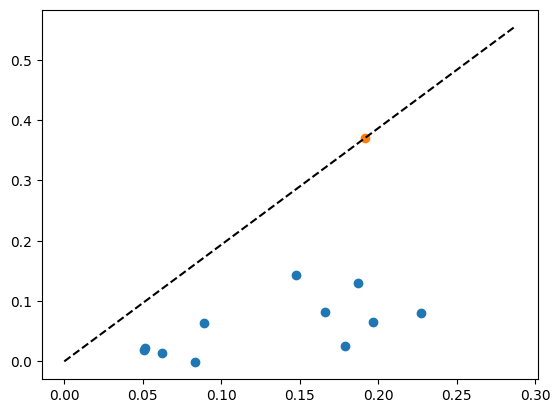

In [239]:
plt.scatter(df_summary_stats['Volatility'], df_summary_stats['Mean'])
plt.scatter(df_mvo_summary_stats['Volatility'], df_mvo_summary_stats['Mean'])
rf = 0.00
plt.plot([0,df_mvo_summary_stats['Volatility'][0]*1.5], [rf, df_mvo_summary_stats['Mean'][0]*1.5], color='black', linestyle='--')
plt.show()

## 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

### 4.1 Removing TIPS

In [246]:
df_excess_return_m_tips = df_excess_returns.drop(columns=["TIP"])
vec_optimal_weights_m_tips = calculate_optimal_portfolio_weights(df_excess_return_m_tips.iloc[:,1:])
vec_optimal_weights_m_tips
# vec_mvo_port_m_tips_rseries = df_excess_return_m_tips.iloc[:,1:].values @ vec_optimal_weights_m_tips.T
# vec_mvo_port_m_tips_rseries = pd.DataFrame(vec_mvo_port_m_tips_rseries, index=df_excess_return_m_tips["Date"], columns=["MVO (-TIPS) Portfolio"])
# df_mvo_m_tips_summary_stats = er_to_summary_stats(vec_mvo_port_m_tips_rseries, scale=12)
# df_mvo_m_tips_summary_stats
# vec_mvo_port_m_tips_rseries

array([-1.51280154,  0.05516072,  0.27809014,  0.44152349,  1.59317754,
        2.21253256, -0.24590161, -1.31413144, -3.23910662,  2.73145678])

The tangency portfolio's performance seems to have increased when TIPS were removed from the investment universe.

### 4.2 Increasing TIPS by 0.0012

In [227]:
df_excess_returns_adj_tips = df_excess_returns.copy()
df_excess_returns_adj_tips["TIP"] = df_excess_returns_adj_tips["TIP"] + 0.0012
df_excess_returns_adj_tips

,Date,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
0,1969-12-31 18:00:39.933,0.008440,-0.001553,0.155029,0.114637,0.137907,-0.028006,0.295598,0.229649,0.022329,0.098793,-0.017305
1,1969-12-31 18:00:39.964,0.054143,0.163134,0.159871,0.132389,0.029026,-0.020302,0.023198,0.054363,0.028336,0.058924,0.021638
2,1969-12-31 18:00:39.994,0.004550,-0.026858,-0.023094,-0.014647,0.032918,-0.006170,-0.025462,0.041443,-0.004035,-0.001253,0.002583
3,1969-12-31 18:00:40.025,0.031312,0.018595,0.110173,0.100442,0.069218,0.008344,0.105826,0.143274,0.015353,0.074633,0.002106
4,1969-12-31 18:00:40.056,0.007192,-0.040801,-0.013572,0.044595,-0.017405,0.007198,0.131503,0.032977,-0.004587,0.036503,0.009178
...,...,...,...,...,...,...,...,...,...,...,...,...
168,1969-12-31 18:00:45.046,-0.005609,-0.010679,-0.011460,0.026266,-0.001076,0.005051,0.006090,0.031522,0.002038,0.012878,-0.001379
169,1969-12-31 18:00:45.077,-0.029213,-0.067345,-0.027276,-0.043324,-0.015568,-0.017636,-0.043519,-0.022374,-0.009725,0.001363,-0.014014
170,1969-12-31 18:00:45.107,0.003433,0.024730,0.039240,0.039952,0.013053,-0.017301,0.052634,0.042028,0.017878,0.060051,-0.006947
171,1969-12-31 18:00:45.138,0.005978,0.083389,0.056579,0.023199,0.007320,-0.010352,0.013613,0.060803,0.015608,0.028897,-0.002225


In [250]:
vec_optimal_weights = calculate_optimal_portfolio_weights(df_excess_returns_adj_tips.iloc[:,1:])
vec_optimal_weights = pd.DataFrame(vec_optimal_weights, index=df_excess_returns_adj_tips.columns[1:],columns=["MVO (adj TIPS) Weighting"]).sort_values(by="MVO (adj TIPS) Weighting", ascending=False)
vec_optimal_weights

,MVO (adj TIPS) Weighting
SPY,1.992028
TIP,1.866959
HYG,1.257384
IEF,0.546794
EFA,0.501233
EEM,0.188867
DBC,-0.084605
IYR,-0.229565
PSP,-1.089016
BWX,-1.262894


In [228]:
vec_optimal_weights = calculate_optimal_portfolio_weights(df_excess_returns_adj_tips.iloc[:,1:])
vec_mvo_adj_tips_port_rseries = df_excess_returns_adj_tips.iloc[:,1:].values @ vec_optimal_weights.T
vec_mvo_adj_tips_port_rseries = pd.DataFrame(vec_mvo_adj_tips_port_rseries, index=df_excess_returns_adj_tips["Date"], columns=["MVO (adj TIPS) Portfolio"])
# vec_mvo_port_rseries
df_mvo_adj_tips_summary_stats = er_to_summary_stats(vec_mvo_adj_tips_port_rseries, scale=12) 
df_mvo_adj_tips_summary_stats 

,Mean,Volatility,Sharpe
MVO (adj TIPS) Portfolio,0.328917,0.161951,2.030963


The performance of the portfolio increased when TIPS were removed with increased TIPS return. This is most likely due to the optimal portfolio selecting TIPS , hence a higher return on TIPS would reflect as a higher negative return in the optimal portfolio.

# 3. Allocations

### 3.1

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is, $$\wEW_i = \frac{1}{n}$$

In [262]:
num_assets = df_excess_returns.shape[1]-1
vec_equal_weight = np.ones(num_assets) / num_assets
series_weight_to_summary_stats(df_excess_returns.iloc[:,1:], vec_equal_weight, scale=12, target_return=0.12)

,Mean,Volatility,Sharpe
Portfolio Stats,0.12,0.213275,0.562654


#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,
$$\wRP_i = \frac{1}{\sigma_i^2}$$

In [277]:
num_assets = df_excess_returns.shape[1]-1
vec_rp_weight = np.ones(num_assets) / df_excess_returns.iloc[:,1:].var().values
vec_rp_weight
series_weight_to_summary_stats(df_excess_returns.iloc[:,1:], vec_rp_weight, scale=12, target_return=0.12)

,Mean,Volatility,Sharpe
Portfolio Stats,0.12,0.217685,0.551254


#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 
$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$
but this time, use a regularized covariance matrix,
$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$
where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 

In [275]:
df_er_cov = df_excess_returns.iloc[:,1:].cov()
num_assets = df_excess_returns.shape[1]-1
sig_d = np.zeros((num_assets, num_assets))
np.fill_diagonal(sig_d, np.diag(df_er_cov))
df_er_cov_reg = (df_er_cov + sig_d) / 2
vec_optimal_weights = calculate_optimal_portfolio_weights(df_excess_returns.iloc[:,1:], custom_cov_matrix=df_er_cov_reg.values)
vec_reg_rseries = pd.DataFrame(df_excess_returns.iloc[:,1:].values @ vec_optimal_weights.T, index=df_excess_returns_adj_tips["Date"], columns=["MVO (REG) Portfolio"])
df_reg_summary_stats = er_to_summary_stats(vec_reg_rseries, scale=12)
target_return = 0.12
df_reg_summary_stats["Mean"] = target_return
df_reg_summary_stats["Volatility"] = target_return / df_reg_summary_stats["Sharpe"]
df_reg_summary_stats

,Mean,Volatility,Sharpe
MVO (REG) Portfolio,0.12,0.094096,1.275297


### 3.2 Conclusions

We can see that using a regularized MVO results in the best sharpe (performance) because it is the least constrained optimization out of the 3 methods we used in this final section. With the equal weighted portfolio, the sharpe is much lower because the weights are constrained and no optimization is occuring. With the risk parity portfolio, the weights are only optimized to avoid risk with a complete disregard for any mean return, thus it also does not have the "Mean-Variance" optimization going on.

With the final conclusions of this assignment, I would like to note that, although MVO produces the highest sharpe, the risk parity and equal weighted portfolios should not be dismissed completely as both the Regularized MVO and MVO both heavily rely on the covariance matrix and the pairwise relationships to continue at their current levels. 